In [2]:
# this notebook wants to use our cost function to find best SWAP that lines at points between B and sqswap
# the gates on this line can build SWAP in 2 cases (homogenous basis)
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%matplotlib widget

import sys
sys.path.append("../../../")
import numpy as np

In [3]:
from weylchamber import c1c2c3
from qiskit import QuantumCircuit
from src.utils.custom_gates import RiSwapGate
from qiskit.quantum_info import Operator

In [8]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import ConversionGainSmushGate
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])

t= 1.0
duration_1q = 0.25

# if using riswap
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1), (1,2)]])
basis_str = "riswap"

# varg_offset = 2 #set to 4 if want to use phase, and change 0s to vargs in pp2 constructor below
# pp2 =lambda *vargs: ConversionGainSmushGate(0,0 , vargs[0], vargs[1], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q"

# varg_offset = 4
# pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q+P"


basis.build(2)
basis.spanning_range = range(1,2)

#for all smush gates make bounds
bounds_1q = 4*np.pi
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)

# manually set the gc, gg bounds
for el in basis.circuit.parameters:
    s_el = str(el)
    if s_el in ["Q0", "Q1", "Q22", "Q23", "Q44", "Q45"]:
        basis.add_bound(s_el, .5, 0)
        #basis.add_bound(s_el, 0.5*np.pi, 0) #XXX when using riswapgate should be 0.5, but when using ConversionGain should be np.pi/2 !!! BAD BAD BAD


from src.sampler import HaarSample, GateSample
from qiskit.circuit.library import CXGate, CZGate, SwapGate, iSwapGate
sampler = GateSample(gate = SwapGate())
#sampler = GateSample(gate = iSwapGate().power(1/2))
s = [s for s in sampler][0]

from src.optimizer import TemplateOptimizer
from src.cost_function import BasicCostInverse, BasicCost, BsqSwapCost, MutualInformation
objective1 = BasicCost()
objective2 = BsqSwapCost()
optimizer3 = TemplateOptimizer(basis=basis, objective=objective3, use_callback=True, override_fail=True, success_threshold = 1e-7, training_restarts=1)

In [9]:
ret3 = optimizer3.approximate_from_distribution(sampler) #get coordinate list

INFO:root:Starting sample iter 0
INFO:root:Begin search: (0.5, 0.5, 0.5)
INFO:root:Starting opt on template size 1
100%|██████████| 1/1 [00:08<00:00,  8.73s/it]
INFO:root:Cycle (k =1), Best Loss=2.6008760366928483
INFO:root:Overall Best Loss=2.6008760366928483


TypeError: scatter() missing 3 required positional arguments: 'c1', 'c2', and 'c3'

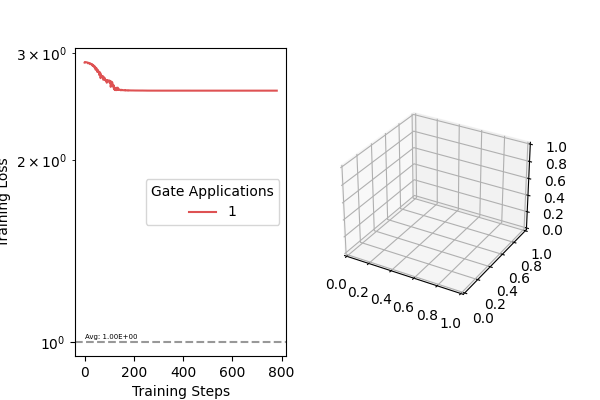

In [10]:
from src.utils.visualize import optimizer_training_plot
optimizer_training_plot(ret3[0], ret3[1]);

Next, we want to use our binary search constraining circuit cost to find lower the circuit cost where it meets the SWAP-pair line


In [1]:
# Here we want to save the best cost as a function of the success threshold
# success_thresholds = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
# fidelities = [None]*len(success_thresholds)
# for k, success_threshold in enumerate(success_thresholds):
#     objective1 = BasicCost()
    
# keep trying until success_threshold converges:
i=0
LB = 0
UB = 1.5
current_cost = (UB + LB)/2
print(f"Starting cost = {current_cost}")

# keep trying until success_threshold converges:
while i == 0 or np.abs(current_cost - previous_cost) > 0.01:
    if not current_cost is None:
        basis.set_constraint(param_max_cost=current_cost)
        #pass
    #rebuild optimizer to refresh the updated f_basis obj
    #NOTE setting the success threshold low since SWAP is very hard to find exactly
    optimizer3 = TemplateOptimizer(basis=basis, objective=objective2, use_callback=True, override_fail=True, success_threshold = 1e-7, training_restarts=5)

    _ret3 = optimizer3.approximate_target_U(s)
    current_cost = basis.circuit_cost(_ret3.Xk)
    print(f"Iteration:{i}, Decomposition Result:{_ret3.loss_result}, Cost:{current_cost},")

    #search using 2 steps forward, 1 step back approach BAD
    # I want to do a binary search between 0 and 1.5 
    # if success, then set next cost to be current - LB / 2
    # if fail, then set next cost to be current + (UB - current) / 2
    
    if _ret3.success_label:
        ret3 = _ret3
        #fidelities[k] = ret3

        #success means can tighten the constraint
        previous_cost = current_cost
        current_cost = (current_cost + LB)/2
        print("Success, new cost:", current_cost)
        #update UB
        UB = previous_cost

    else:
        #fail means loosen the constraint
        previous_cost = current_cost
        current_cost = (current_cost + UB)/2
        print("Fail, new cost:", current_cost)
        #update LB
        LB = previous_cost

    i+=1

    # # save fidelities to h5 file
    # with h5py.File(f'swap_fidelities_{basis_str}.h5', 'a') as hf:
    #     #if dataset exists, delete it
    #     if f"success_{success_threshold}" in hf:
    #         del hf[f"success_{success_threshold}"]
    #     hf.create_dataset(f"success_{success_threshold}", data=fidelities[k])

Starting cost = 0.75


NameError: name 'basis' is not defined

TypeError: scatter() got multiple values for argument 'c'

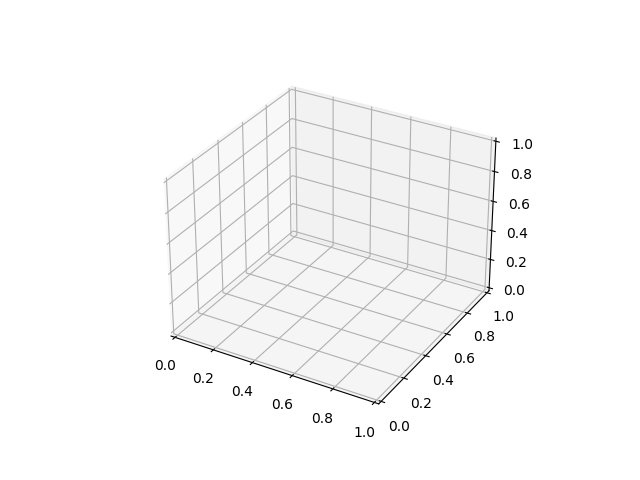

In [12]:
from src.utils.visualize import coordinate_2dlist_weyl
fig = coordinate_2dlist_weyl(ret3[1], c=range(len(ret3[1])));
# add onto figure segment from B to sqswap
ax = fig.gca()
ax.plot([.5,.75], [.25, .25], [0, .25], 'k--');
ax.plot([.5,.25], [.25, .25], [0, .25], 'k--');

Cost: 0.9834141506352956


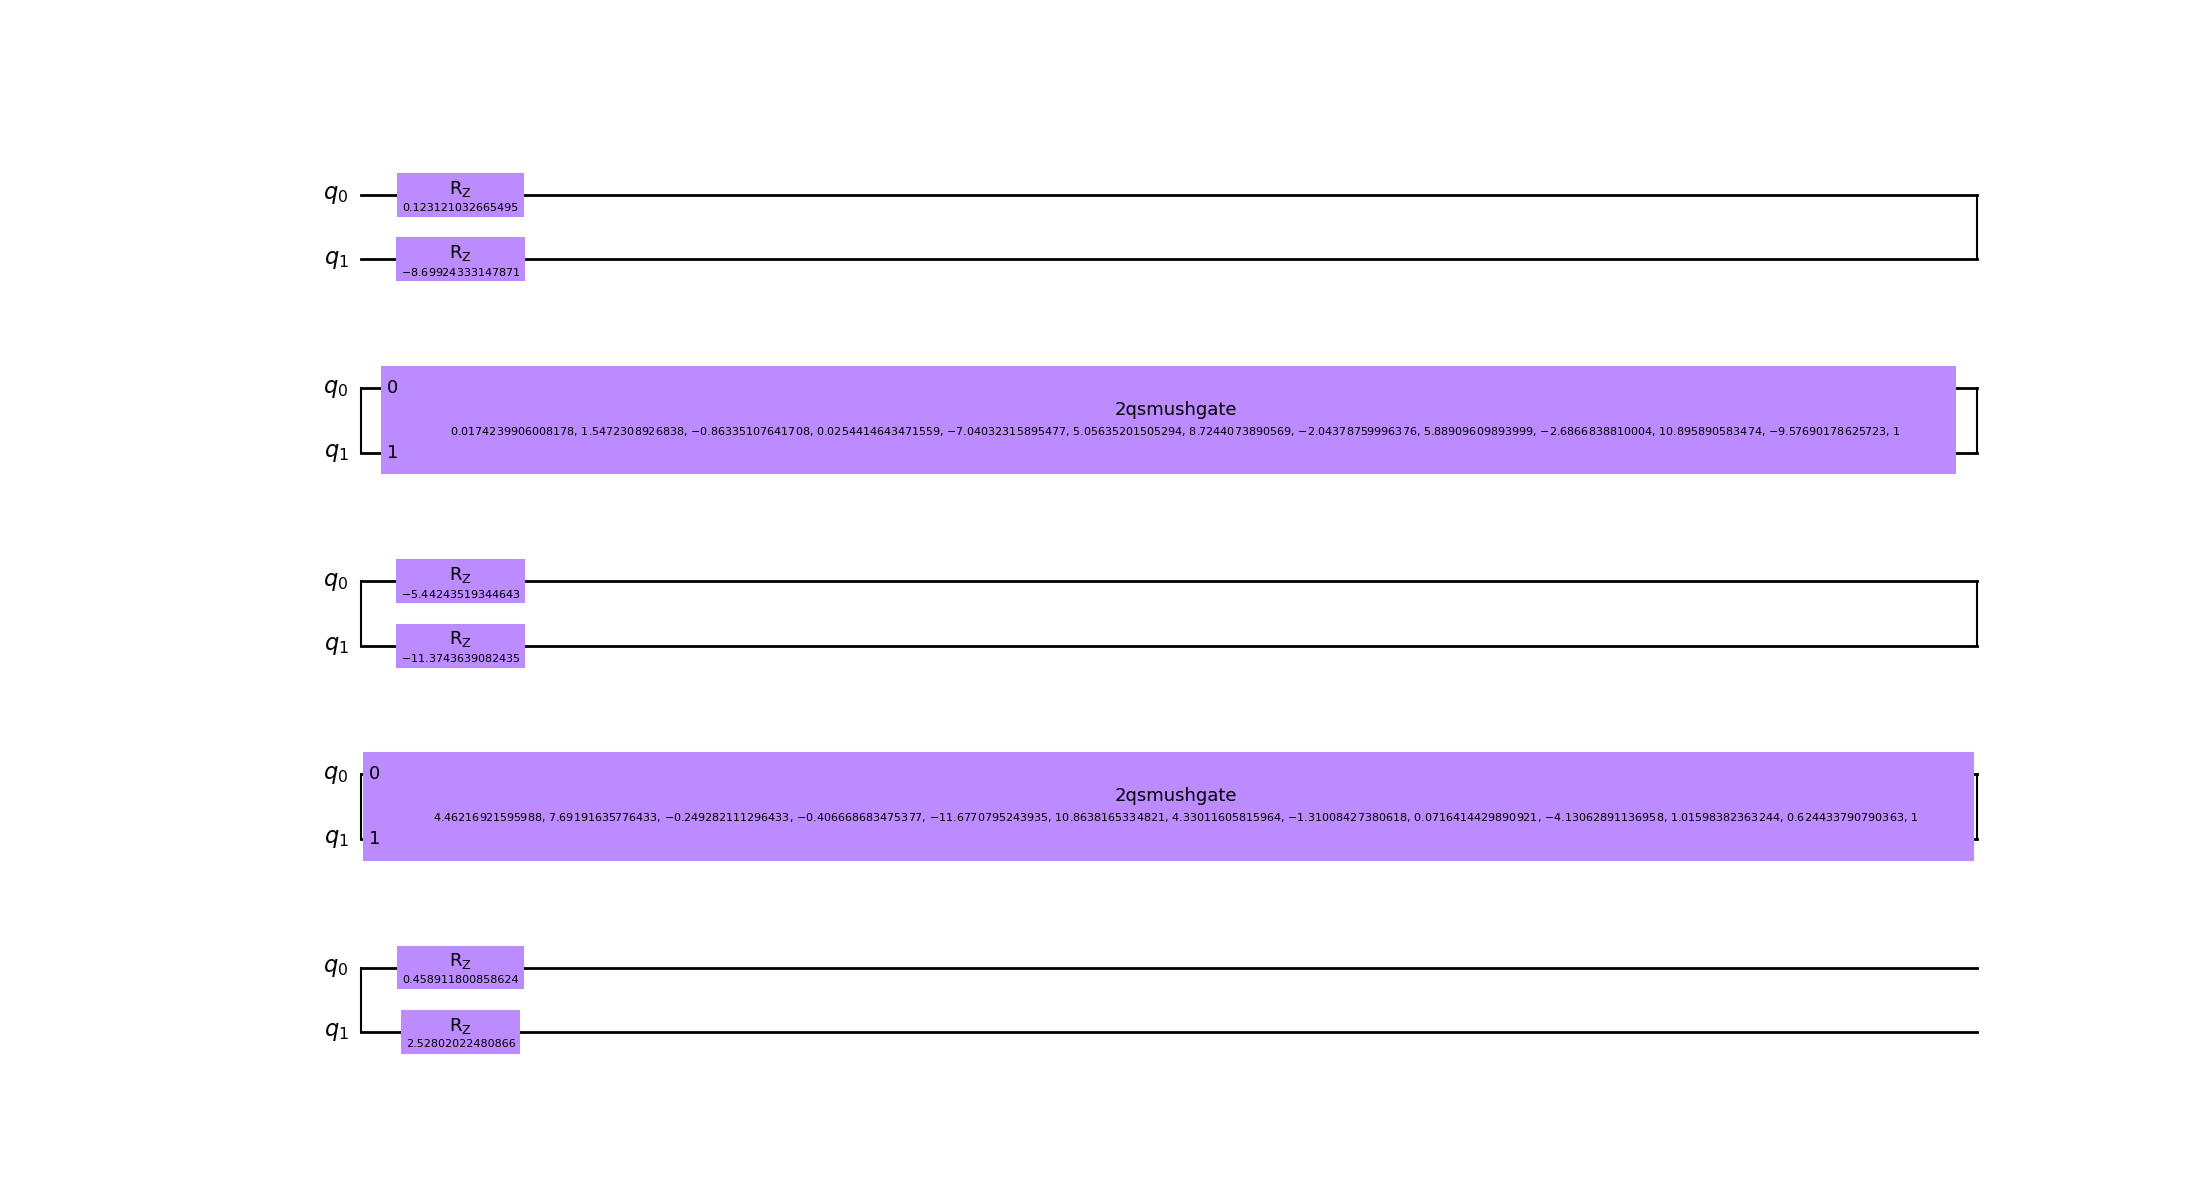

In [13]:
# _ret3 = optimizer3.approximate_target_U(s)
circuit =basis.assign_Xk(_ret3.Xk)
print("Cost:", basis.circuit_cost(Xk=_ret3.Xk))
circuit.draw(output='mpl');